# Rutina Principal de Trabajo Final 
## Analítica Predictiva 

Realizado por: 

*   Luis Gabriel Díaz Fonseca
*   Eduardo Alberto González Escobar
*   Diego Mayorga
*   Cristian Camilo Londoño Ramírez

Profesores:

*   Juan David Velásquez
*   Fernan Aloso Villa

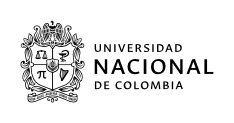

# inicio

## instalar libreria

In [3]:
!pip install sodapy

## Importar modulos

In [4]:
# modulos para la descarga
import pandas as pd
from sodapy import Socrata
import datetime
import pickle
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import mean_squared_error
import warnings

from scipy.integrate import odeint

from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Descargar


Fuentes de información:
Como principal fuente de datos, recurrimos [open data Colombia](https://www.datos.gov.co/) , allí consultamos los datos abiertos del Instituto Nacional de Salud y para lo cual  usamos el cliente sodapy de Python para poder consumir los datos  Socrata .

## [Casos positivos de COVID-19 en Colombia:](https://dev.socrata.com/foundry/www.datos.gov.co/gt2j-8ykr)

In [5]:
class Descarga():

  def __init__(self):
    self.fuentes = {}
    self.getFuentes()

  def actualizarFuente(self,fuente):
    # realiza la descarga de la fuente
    df = []
    cliente = Socrata(fuente[2], None)
    identificador_datos = fuente[3]
    # descargar df
    datos = cliente.get(identificador_datos,limit=10**8)
    df = pd.DataFrame.from_records(datos)
    return df 

  def getFuentes(self):
    # gestiona las fuentes, si no se debe actulizar busca dentro de la carpeta la fuente
    ## buscar todas las fuentes
    info_fuente = (1, 'casosColombia', 'www.datos.gov.co', 'gt2j-8ykr', '2020-08-23')
    self.fuentes[str(info_fuente[1])] = self.actualizarFuente(info_fuente)

  def leerArchivo(self,nombre):
    with open(nombre, 'rb') as archivo:
      datos = pickle.load(archivo)
      return(datos)

  def guardarArchivo(self,datos,path):
    nombreArchivo = path
    with open(nombreArchivo,'wb') as archivo:
      pickle.dump(datos,archivo)
      archivo.close()

# Descriptiva

## Area

In [6]:
class Area():

  def __init__(self,nombre,columnas,max=120,long_rango=10):
    self.nombre = nombre
    self.arreglo_df = ["","",""]
    self.columnas = columnas
    self.rango = list(map(lambda x : str([x + 1 , x + 11]),list(np.arange(-1, max-long_rango,long_rango))))
    self.dic_info = {}
    self.dic_historicos = {}
    self.dic_serie_tiempo = {}

############################ metodos basicos ##################################

  def agrupar_edad(self,df_datos,long_rango = 10,max = 120):
    """
      toma el df, limpia las filas y retorna un df con los rangos de edad y la 
      para cada uno de ellos
      # df_datos : dataframe de los datos (pandas df)
      # long_rango : longitud de los datos (int)
      # max : edad maxima  (int)
      => diccionario con las etiquetas y los datos
    """
    df1 = df_datos.copy()[[self.columnas[3],self.columnas[0]]] # solo toma del df 2 columnas
    df1 = df1[pd.isnull(df1[self.columnas[3]])==False ] # quitar los nulos
    df1[self.columnas[3]] = pd.to_numeric(df1[self.columnas[3]]) # pasar de str a numeros
    df_edad = df1.groupby(pd.cut(df1[self.columnas[3]], np.arange(-1, max, long_rango))).count()[columnas[3]] # organizar en rangos
    
    #return df_edad
    return {"etiqueta" : self.rango , "datos" : list(map(int,list(df_edad.values))) }


  def agrupar_categoria(self,df_dato,col):
    """
      ****  funciona para : atencion, sexo, tipo, estados ****
      Toma el df , agrupa y cuanta la frecuencia para cada categoria 
      # df_datos : dataframe de los datos (pandas df)
      # col : numero de la columna que se va a agrupar (int)
      => diccionario con las etiquetas y los datos
    """
    df1 = df_dato.copy()[[self.columnas[col],self.columnas[0]]]
    grupo = df1.groupby(self.columnas[col]).count()[self.columnas[0]]
    
    #return grupo
    return {"etiqueta" : list(grupo.index) , "datos" : list(map(int,list(grupo.values))) }

  def generar_historicos_acumulado(self,df_dato,col):
    """
      toma el df, pasa las fechas de la columna seleccionda a formato fecha,
      elimina las filas que no tenga fechas y acumula la frecuencia para cada 
      fecha
      # df_datos : dataframe de los datos (pandas df)
      # col : numero de la columna que se va a agrupar (int)
      => diccionario con las etiquetas y los datos
    """
    df1 = df_dato.copy()[[self.columnas[col],self.columnas[0]]] # toma solo las columnas necesarias
    df1[col] = pd.to_datetime(df1[self.columnas[col]],errors="coerce") # pasa a fecha 
    df1 = df1[pd.isnull(df1[self.columnas[col]])==False ] # quitar los nulos
    acumulado = df1.groupby(self.columnas[col]).count()[self.columnas[0]].cumsum() # contar casos acumulados para cada dia
    serie_timepo = df1.groupby(self.columnas[col]).count()[self.columnas[0]]

    #return acumulado
    return [{"etiqueta" : 
            list(map(lambda x : str(x)[0:10],list(acumulado.index))) , 
            "datos" : list(map(int,list(acumulado.values)))},
            acumulado,
            serie_timepo]

###########################  metodo compuesto  ################################# 

  def analizar_df(self,df_dato,col_fecha,tipo):
    """
      toma el df y realizarle toda la descriptiva
      # df_datos : dataframe de los datos (pandas df)
      # col_fecha : columna de las fechas para hacer el historico (int)
      => info_dic :  diccionario con toda la informacion
    """
    info_dic = {}

    info_dic["edad"] = self.agrupar_edad(df_dato)
    info_dic["sexo"] = self.agrupar_categoria(df_dato,4)
    historico = self.generar_historicos_acumulado(df_dato,col_fecha)
    info_dic["historico"] = historico[0]
    self.dic_historicos[tipo] = historico[1]
    self.dic_serie_tiempo[tipo] = historico[2]


    if (col_fecha == 14):

      info_dic["atencion"] = self.agrupar_categoria(df_dato,2)
      info_dic["tipo"] = self.agrupar_categoria(df_dato,5)
      info_dic["estado"] = self.agrupar_categoria(df_dato,6)


    return info_dic
  
  def correr_analisis_completo(self):
    """
      la lista de df y los analiza
      => info_dic :  diccionario con toda la informacion
    """
    self.dic_info = {}

    self.dic_info["casos"] = self.analizar_df(self.arreglo_df[0],14,"caso")
    self.dic_info["recuperado"] = self.analizar_df(self.arreglo_df[1],9,"recuperado")
    self.dic_info["fallecidos"] = self.analizar_df(self.arreglo_df[2],11,"fallecidos")
   

  def guardar_datos(self,datos,ruta_archivo):
    f = open(ruta_archivo, "w")
    f.write(datos)
    f.close()

  def guardar_variables(self,ruta_archivo):
    plantilla = """let j_info = {info}  """ # crea una variables tipo json 
    self.guardar_datos(plantilla.format(info=json.dumps(self.dic_info)),ruta_archivo)

## Pais

In [7]:
class Pais (Area):

  """
  clase que hereda funciones de area, encargada de cargar los datos de todo el
  pais, eliminar las columnas inecesarias, crear df para recuperados y fallecidos
  tomar solo los datos para las ciudades, crear objetos para cada ciudad.
  """

  def __init__(self,nombre,columnas,arreglo_ciudades):
    Area.__init__(self,nombre,columnas)
    self.df_completos = []
    self.arreglo_ciudades = arreglo_ciudades
    self.objetos_ciudades = {}
    self.ciudades = {}
    self.arreglo_historicos = {}
    self.arreglo_serie_tiempo = {}
    self.run()

  def run(self):
    self.cargar_datos()
    self.eliminar_columnas_filas()
    self.separar_DF()
    self.crear_objetos_ciudad()
    #self.guardar_variables("variables.js")
  

  def cargar_datos(self):
    """
      carga el df que esta serializado
    """
    d = Descarga()
    d.fuentes
    self.df_completos = d.fuentes["casosColombia"]

  def eliminar_columnas_filas(self):
    """
      toma el df con todos los datos del pais y todas las columnas, elimina las 
      columnas innecesarias y solo toma las filas con las ciudades a analizar
    """
    ciudades = list(map(lambda x : x["nombre"],self.arreglo_ciudades))
    df = self.df_completos.copy()
    df = df[self.columnas]
    df = df[df["ciudad_de_ubicaci_n"].isin(ciudades)]
    self.arreglo_df[0] = df # df casos 

  def separar_DF(self):
    """
      toma el df de arreglo_df[0] y crea el arreglo_df[1] para los recuperados y
      arreglo_df[2] para los fallecidos
    """
    # crear df recuperados
    df_rec = self.arreglo_df[0].copy() # copiar del df 
    df_rec = df_rec[pd.isnull(df_rec["fecha_recuperado"])==False ] # tiene que tener fecha de recuperacion
    df_rec = df_rec[pd.isnull(df_rec["tipo_recuperaci_n"])==False ] # tiene que tener tipo de recuperacion
    
    self.arreglo_df[1] = df_rec # df recuperados

    # crear df fallecidos

    df_fall = self.arreglo_df[0].copy() # copiar del df
    df_fall = df_fall [df_fall ["atenci_n"]!="N/A"] # peronas que murieron por covid
    df_fall = df_fall [pd.isnull(df_fall["tipo_recuperaci_n"])==True] # no tiene tipo de recuperacion
    df_fall = df_fall [pd.isnull(df_fall["fecha_recuperado"])==True]  # no tiene fecha de recuperacion
    df_fall["fecha_de_muerte"] = pd.to_datetime(df_fall["fecha_de_muerte"],errors="coerce") # pasas la fecha de strin a fecha
    df_fall = df_fall[pd.isnull(df_fall["fecha_de_muerte"])==False] # ver cuales filas tiene fecha de muerte

    self.arreglo_df[2] = df_fall # df fallecidos

  def crear_objetos_ciudad(self):

    """
      toma los 3 df(casos , recuperados y fallecidos) y los divide en las 
      ciudades para crear objetos Ciudad que seran almacenados en un diccionario, 
      como clave el nombre de cada ciudad
    """
    # agrupar los df 
    grupo_casos_ciudad = self.arreglo_df[0].groupby("ciudad_de_ubicaci_n")
    grupo_recuperados_ciudad = self.arreglo_df[1].groupby("ciudad_de_ubicaci_n")
    grupo_fallecidos_ciudad = self.arreglo_df[2].groupby("ciudad_de_ubicaci_n")
    
  
    # llenar el diccionario con los objetos
    for ciudad in  ciudades:
      c = Ciudad(ciudad["nombre"],self.columnas,
                                              [grupo_casos_ciudad.get_group(ciudad["nombre"]),
                                              grupo_recuperados_ciudad.get_group(ciudad["nombre"]),
                                              grupo_fallecidos_ciudad.get_group(ciudad["nombre"]),
                                              ],
                 ciudad["poblacion"])   
      self.objetos_ciudades[ciudad["nombre"]] = c

      self.dic_info[ciudad["nombre"]] = c.dic_info
      self.ciudades[ciudad["nombre"]] = c.arreglo_df
      self.arreglo_historicos[ciudad["nombre"]] = c.dic_historicos
      self.arreglo_serie_tiempo[ciudad["nombre"]] = c.dic_serie_tiempo
  
  def guardar_objetos(self,datos,ruta_archivo):
    with open(ruta_archivo,'wb') as archivo:
      pickle.dump(datos,archivo)
      archivo.close()


## Ciudad

In [8]:
class Ciudad (Area):

  def __init__ (self,nombre,columnas,arreglo_df,poblacion):
    Area.__init__(self,nombre,columnas)

    self.casos_activos = []
    self.casos_suceptinbles = []
    self.casos_restantes = []
    self.df_datos_modelos = []
    self.casos_fallecidos = []
    self.casos_recuperados = []
    self.poblacion = - 1

    self.factores = {
        "fallecidos" : -1,
        "recuperados" : -1
    }

    self.poblacion = poblacion
    self.arreglo_df = arreglo_df
    self.correr_analisis_completo()
    self.info_df = []

    # modelos
    self.modelo_sir = Modelo_sir()

    arima_activos = Modelo_arima()
    arima_fallecidos = Modelo_arima()
    arima_recuperados = Modelo_arima()

    self.modelo_arima = {
        "activos" : arima_activos,
        "fallecidos" : arima_fallecidos,
        "recuperado" : arima_recuperados
        }

    self.ajustar_modelos()

  def generar_datos_modelos(self):

    # casos activos
    activos = self.dic_historicos["caso"] - self.dic_historicos["recuperado"] - self.dic_historicos["fallecidos"]
    activos = activos.fillna(method='pad')# quitar los nulos tomando el siguiente valor
    activos.index = activos.index.strftime("%Y-%m-%dT%H:%M:%S.000")
    
    self.casos_activos = activos.to_frame()

    # suceptibles 
    suceptinbles = self.poblacion - self.dic_historicos["caso"]

    self.casos_suceptinbles = suceptinbles.to_frame()
    self.casos_suceptinbles['dias'] = np.arange(0, len(self.casos_suceptinbles.index), 1).reshape(-1,1)

    # resto 
    restantes = self.dic_historicos["recuperado"] + self.dic_historicos["fallecidos"] # sumar los casos
    restantes = restantes.dropna()# quitar los nulos
    #restantes.index = restantes.index.strftime("%Y-%m-%dT%H:%M:%S.000")
    
    self.casos_restantes = restantes.to_frame()

    # fallecidos
    recuperados = self.dic_serie_tiempo["recuperado"]
    recuperados = recuperados.dropna()# quitar los nulos
    #recuperados.index = recuperados.index.strftime("%Y-%m-%dT%H:%M:%S.000")

    self.casos_recuperados = recuperados.to_frame()

    # recuperados
    fallecidos = self.dic_serie_tiempo["fallecidos"]
    fallecidos = fallecidos.dropna()# quitar los nulos
    fallecidos.index = fallecidos.index.strftime("%Y-%m-%dT%H:%M:%S.000")

    self.casos_fallecidos = fallecidos.to_frame()

    ## join 
    df = self.casos_suceptinbles.join(self.casos_activos, lsuffix='_suc', rsuffix='_act')
    df = df.join(self.casos_restantes, lsuffix='_suc', rsuffix='_res')
    df = df.join(self.dic_historicos["caso"], lsuffix='_res', rsuffix='_ca')
    

    ## cambiar index

    df["fecha"] = df.index
    df.index = df["dias"]

    # organizar df

    df.rename(columns = {'id_de_caso_suc':'suceptibles',
                        'id_de_caso_act':'activos', 
                          'id_de_caso_res':'resto',
                        'id_de_caso_ca':'casos'}, inplace = True)

    ## llenar las primeras filas con datos
    """
    como no hay muertes o rcuperaciones los primero dias los casos activos seran 
    igual a los casos 
    """
    df['activos'].fillna(df['casos'],inplace = True) 
    """
    para que sea consistente, los valores de los restantes son igaul a el numero de 
    los casos menos los activos
    """
    df['resto'].fillna(df['casos']-df['activos'],inplace = True)  


    df.index = df["fecha"]

    recuperados = self.dic_serie_tiempo["recuperado"].to_frame()
    fallecidos = self.dic_serie_tiempo["fallecidos"].to_frame()

    ## join
    df = df.join(recuperados , lsuffix='_suc', rsuffix='_res')
    df = df.join(fallecidos , lsuffix='_suc', rsuffix='_res')

    df.rename(columns = {'id_de_caso_suc':'recuperado',
                        'id_de_caso_res':'fallecidos'}, 
              inplace = True)
    
    df.index = df["dias"]

    df["recuperado"] = df["recuperado"].fillna(method='pad')
    df["fallecidos"] = df["fallecidos"].fillna(method='pad')

    df['recuperado'].fillna(0,inplace = True) 
    df['fallecidos'].fillna(0,inplace = True) 

    self.info_df = df.copy()[["recuperado","activos","fallecidos"]]

    df = df.apply(self.div_recu, axis=1)
    df = df.apply(self.div_muertos, axis=1)

    self.factores["fallecidos"] = df["R_fallecidos"].mean()
    self.factores["recuperados"] = df["R_recuperados"].mean()

    self.df_datos_modelos = df


  def ajustar_modelos(self):
    print("ajustando modelos",self.nombre)
    # datos
    self.generar_datos_modelos()
    # SIR
    self.modelo_sir.ajustar_parametros(
        list(self.df_datos_modelos["activos"].values),
        list(self.df_datos_modelos["dias"].values),
        self.poblacion)
    # Arma
    tiempo = list(self.df_datos_modelos["dias"].values)

    for modelo in self.modelo_arima:

      self.modelo_arima[modelo].dividir_datos(
          tiempo,
          0.95,
          list(self.df_datos_modelos[modelo].values))
      self.modelo_arima[modelo].ajustar_parametros()

  def div_recu(self,x):
    last_row_id = int(x.name - 1)
    if x.name == -1:
        x['R_recuperados']= 0
    else:
      try :
        x["R_recuperados"] = self.info_df["recuperado"][last_row_id+1]/self.info_df["activos"][last_row_id]
      except :
        x["R_recuperados"] =  0
    return x

  def div_muertos(self,x):
    last_row_id = int(x.name - 1)
    if x.name == -1:
        x['R_fallecidos']= 0
    else:
      try :
        x["R_fallecidos"] = self.info_df["fallecidos"][last_row_id+1]/self.info_df["activos"][last_row_id]
      except :
        x["R_fallecidos"] =  0
    return x



# Modelos

In [9]:
class Modelo():
  """
  es la clase madre para las clases modelo_sir y modelo_arima
  """

  def __init__(self):
    self.parametros_ajuste = {}
    self.error = {}

  def ajustar_parametros(self):
    pass
  
  def predecir(self):
    pass
  


## Modelo ARIMA
El modelo autorregresivo integrado de medias móviles, ARIMA por sus siglas en inglés, es un modelo estadístico que basado en el comportamiento de la señal de una series de tiempo, la autocorrelación que puede existir entre valores secuenciales de la misma serie y los patrones de comportamiento al rededor de una posible media móvil o estacionariedad, puede ser utilizada satisfactoriamente para realizar pronósticos a corto plazo.

El modelo ARIMA($p$,$d$,$q$) puede es descrito con las siguientes ecuaciones:
$Y_t= \big(Y_t-\Delta^dY_t\big) + \big( \alpha_0+\displaystyle\sum_{i=1}^{p}\alpha_i \Delta^dY_{t-i} \big) - \displaystyle\sum_{i=1}^{q}\beta_i\epsilon_{t-i} + \epsilon_t$

El parámetro $p$ se le conoce como el componente autoregresivo de la serie, el parámetro $d$ se le conoce como la componente diferencial y el parámetro $q$ corresponde a la componente de medias moviles del modelo. 

Para escoger el modelo ARIMA que mejor se ajute a los datos, utilizaremos la metrica de error MSE, para esto, se varian los parámetros del modelo donde $p,q \in \{0,1,2,4\}$ y $d \in \{ 0,1\}$, comparando así 50 modelos para cada serie de tiempo y escogiendo el modelo que arroje el menor error cuadratico medio. Además de esto, y teniendo en cuenta que el modelo ARIMA será utilizando para realizar proyecciones a corto plazo, en este caso 7 días de horizonte de pronóstico, los datos se dividiran en entrenamiento y validación, tomando el 95% de los primeros datos para entrenar y el restante 5% para validar para conservar así el orden secuencial de las series de tiempo.

In [10]:
class Modelo_arima(Modelo):

  """
  contiene los metodos necesarios para poder dividir 

  """

  
  def __init__(self,
               rango_p = [0,5],
               rango_d = [0,1],
               rango_q =[0,5]):
    ## heredar funciones de la clase madre
    Modelo.__init__(self)
    ## parametros para dividir la serie en set de ajuste y prueba
    self.fraccion_tiempo = -1
    self.tiempo_entrenamiento = []
    self.y_entrenamiento = []
    self.tiempo_validacion = []
    self.y_validacion = []
    # rangos para la validacion de los parametros
    self.rango_p = rango_p
    self.rango_d = rango_d
    self.rango_q = rango_q

    self.modelo_entrenado = []
    self.tiempo_inicio_serie = -1
    self.tiempo_fin_serie = -1
  

  def dividir_datos(self,tiempo,porcentaje_entrenamiento,datos_reales):
    """
    divide la serie de tiempo para el entrenamineto y la validacion, toma el
    porcentaje de entrenamiento y crea los dos set de datos 
    (entrenamiento y validacion )
    """
    # calcular la cantidad de datos para el entrenamiento
    self.fraccion_tiempo = int(len(tiempo)* porcentaje_entrenamiento)

    # dividir los datos para el entrenamineto
    self.tiempo_entrenamiento = tiempo[:self.fraccion_tiempo]
    self.y_entrenamiento = datos_reales[:self.fraccion_tiempo]

    # dividir los datos para la prueba
    self.tiempo_validacion = tiempo[self.fraccion_tiempo:]
    self.y_validacion = datos_reales[self.fraccion_tiempo:]

    # parametros para predecir serie
    self.tiempo_inicio_serie = len(self.y_entrenamiento)
    self.tiempo_fin_serie = len(self.y_entrenamiento) + len(self.y_validacion) - 1


  def ajustar_parametros(self):

    warnings.filterwarnings("ignore") # quitar las alertas 

    coeficientes_optimos = [] 
    error = 0
    iteracion = 0

    # realizar iteraciones 
    for p in range (self.rango_p[0],self.rango_p[1]+1):
      for d in range (self.rango_d[0],self.rango_d[1]+1):
        for q in range (self.rango_q[0],self.rango_q[1]+1):


          if ((p==0) and (q == 0) and (d==0)):
            pass # no usar todos los coeficientes en cero

          else :

            try:
              resultado = SARIMAX(self.y_entrenamiento,
                                  order = (p, d, q),
                                  enforce_invertibility=False).fit()   
                                                
              error_iteracion = mean_squared_error(self.y_validacion,
                                                    resultado.predict(self.tiempo_inicio_serie, 
                                                                      self.tiempo_fin_serie, 
                                                                      typ = 'levels'))

              if (iteracion == 0):

                error = error_iteracion
                coeficientes_optimos = [p,d,q]
                iteracion = iteracion + 1

              else:

                if (error > error_iteracion):
                  error = error_iteracion
                  coeficientes_optimos = [p,d,q]

              """print("*p : " , p ,
                    " *d : ", d , 
                    " *q : " , q ,
                    " error iteracion : " , error_iteracion ,
                    " error minimo : ", error)"""
            except :
              pass

    # pasar los parametros optimos a la varaible global      
    self.parametros_ajuste["p"] = coeficientes_optimos[0]
    self.parametros_ajuste["d"] = coeficientes_optimos[1]
    self.parametros_ajuste["q"] = coeficientes_optimos[2]

    # pasar el error de validacion a la varaible global
    self.error["validacion"] = error

    # hacer el fit con los parametros optimos
    self.modelo_entrenado = SARIMAX(self.y_entrenamiento,
                                    order = (coeficientes_optimos[0], 
                                                   coeficientes_optimos[1], 
                                                   coeficientes_optimos[2]),
                                    enforce_invertibility=False).fit()

  def predecir(self,inicio_serie,fin_serie):

    warnings.filterwarnings("ignore")

    prediccion = self.modelo_entrenado.predict(inicio_serie,
                                               fin_serie,
                                               typ = 'levels')

    return  prediccion



## Modelo SIR

EL **modelo SIR** es un modelo simple que permite capturar muchas de las características típicas de los brotes epidémicos.
El modelo relaciona las variaciones de las tres poblaciones (Susceptible, Infectada y Recuperada) a través de la tasa de infección y el período infeccioso promedio.

* **(S)**:(Pobación **S**uceptible): individuos sin inmunidad al agente infeccioso, y que por tanto puede ser infectada si es expuesta al agente infeccioso.
* **(I)**:(Población **I**nfectada): individuos que están infectados en un momento dado y pueden transmitir la infección a individuos de la población susceptible con la que entran en contacto.
* **(R)**:(Población **R**ecuperada): individuos que son inmunes a la infección (o fallecidos), y consecuentemente no afectan a la transmisión cuando entran en contacto con otros individuos.

La población total es $N=S+I+R$. Lo cual  hace necesario especificar las siguientes ecuaciones diferenciales que describen la variación temporal del número de individuos en cada compartimento:


$
\frac{dS}{dt} =-\beta SI   \\
\frac{dI}{dt} =+\beta SI - \gamma I  \\
\frac{dR}{dt} = \gamma I \\
$


Aquí, la tasa de transmisión $\beta$ y la tasa de recuperación $\gamma$ (de tal manera que el período medio de recuperación es $ \frac{1}{\gamma}$).

In [11]:
class Modelo_sir(Modelo):

  """

  """

  def __init__(self,
               infectados_iniciales = 1,
               restantes_iniciales = 0,
               rango_beta = [0.001,0.99],
               rango_gamma = [1/30,0.5],
               paso_beta = 0.01,
               paso_gamma = 0.01
               ):
    
    Modelo.__init__(self)

    self.poblacion = - 1

    self.infectados_iniciales = infectados_iniciales
    self.restantes_iniciales = restantes_iniciales
    self.susceptible = - 1
    self.rango_beta = rango_beta
    self.rango_gamma = rango_gamma
    self.paso_beta = paso_beta
    self.paso_gamma = paso_gamma


  def derivadas_sir(self,state, t, N, beta, gamma):
    S, I, R = state
    # Cambio de la poblacion suceptible
    dSdt = -beta * S * I / N
    # Cambio de la poblacion infectada
    dIdt = beta * S * I / N - gamma * I
    # Poblacion restante
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


  def ajustar_parametros(self,datos_reales,tiempo,poblacion):

    self.susceptible = poblacion - self.infectados_iniciales - self.restantes_iniciales
    rango_beta =  np.arange(self.rango_beta[0],self.rango_beta[1],self.paso_beta).reshape(-1,1) # bogota
    rango_gamma =  np.arange(self.rango_gamma[0],self.rango_gamma[1], self.paso_gamma).reshape(-1,1)

    coeficientes_optimos = [] 
    error = 0
    iteracion = 0

    for beta in rango_beta: # variar el beta
      for gamma in rango_gamma: # variar el gamma

        try:
          resultado = odeint(self.derivadas_sir,
                            [self.susceptible, self.infectados_iniciales, self.restantes_iniciales],
                            tiempo,
                            args=(poblacion, beta[0], gamma[0])) 
          
          error_iteracion = mean_squared_error(datos_reales, list(resultado .T[1]))
          
          if (iteracion == 0 ):

            error = error_iteracion
            coeficientes_optimos = [beta[0],gamma[0]]
            iteracion = iteracion + 1

          else:

            if ((error > error_iteracion)):

              error = error_iteracion
              coeficientes_optimos = [beta[0],gamma[0]]

          """print("*beta : " , beta[0] ,
                    " *gamma : ", gamma[0] , 
                    " error iteracion : " , error_iteracion ,
                    " error minimo : ", error)"""
        except :
          pass

    self.parametros_ajuste["beta"] = coeficientes_optimos[0]
    self.parametros_ajuste["gamma"] = coeficientes_optimos[1]

    self.error["validacion"] = error
    self.poblacion = poblacion


                                        
  def predecir(self,tiempo):

    prediccion = odeint(self.derivadas_sir,
                            [self.susceptible, self.infectados_iniciales, self.restantes_iniciales],
                            tiempo,
                            args=(self.poblacion, self.parametros_ajuste["beta"], self.parametros_ajuste["gamma"])) 

    return  prediccion


# Cargar datos
Crear un objeto con toda la informacion necesaria para poder realizar la prediccion de la dinamica del virus en cada un da las ciudades

In [12]:
columnas = [
            "id_de_caso",
            "ciudad_de_ubicaci_n",
            "atenci_n",
            "edad",
            "sexo",
            "tipo",
            "estado",
            "fis",
            "fecha_diagnostico",
            "fecha_recuperado",
            "tipo_recuperaci_n",
            "fecha_de_muerte",
            "nombre_grupo_etnico",
            "fecha_de_notificaci_n",
            "fecha_reporte_web"
            ]
ciudades = [
            {"nombre":"Bogotá D.C.","poblacion" : 7.743*10**6},
            {"nombre":"Cali","poblacion" : 2.172*10**6},
            {"nombre":"Barranquilla","poblacion" : 1.205*10**6},
            {"nombre":"Cartagena de Indias","poblacion" : .876*10**6},
            {"nombre":"Medellín","poblacion" : 2.382*10**6}
            ]

Colombia = Pais("Colombia",columnas,ciudades)

ajustando modelos Bogotá D.C.
ajustando modelos Cali
ajustando modelos Barranquilla
ajustando modelos Cartagena de Indias
ajustando modelos Medellín


## ver modelos ajustados

Bogotá D.C. {'beta': 0.571, 'gamma': 0.4933333333333334}
Cali {'beta': 0.5509999999999999, 'gamma': 0.4933333333333334}
Barranquilla {'beta': 0.5909999999999999, 'gamma': 0.4933333333333334}
Cartagena de Indias {'beta': 0.5509999999999999, 'gamma': 0.4933333333333334}
Medellín {'beta': 0.5609999999999999, 'gamma': 0.4933333333333334}


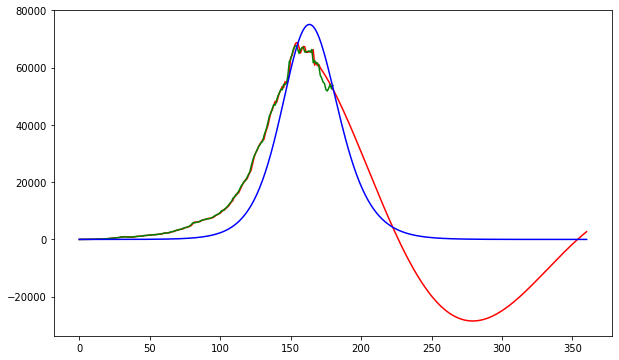

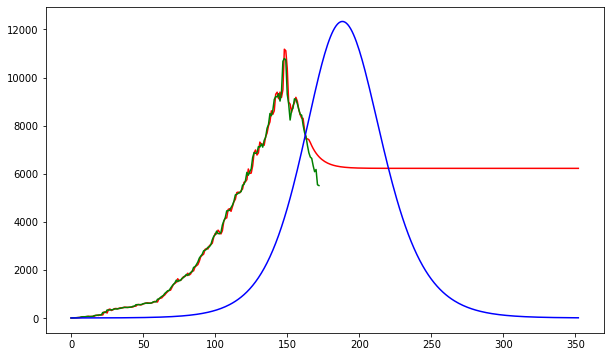

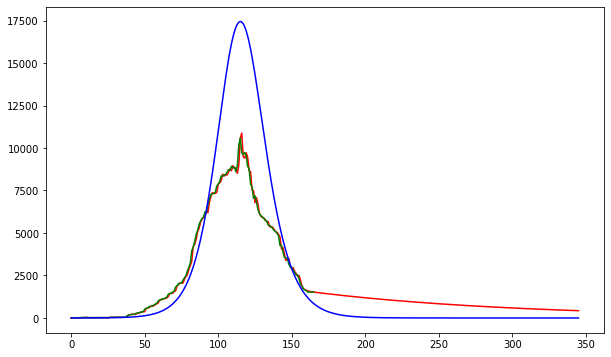

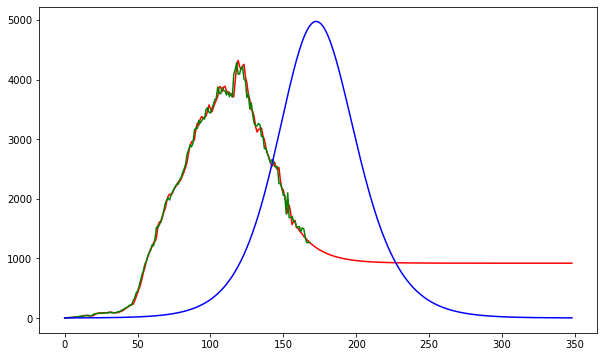

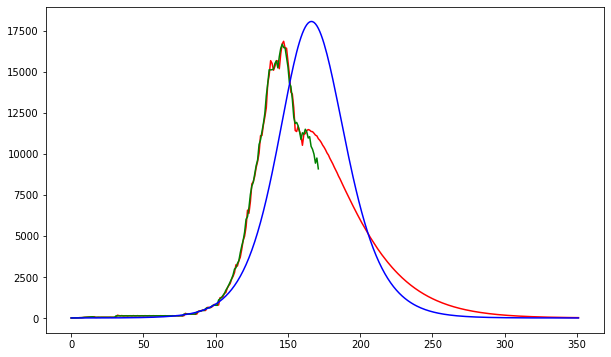

In [ ]:
for ciudad in  Colombia.objetos_ciudades:
  print(ciudad,
        "parametros modelos sir :",Colombia.objetos_ciudades[ciudad].modelo_sir.parametros_ajuste,
        "Parametros modelo arima :",Colombia.objetos_ciudades[ciudad].modelo_arima["activos"].parametros_ajuste )
  # dias predecir 
  dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad].df_datos_modelos["activos"].values))+180))
  resultado_sir  = Colombia.objetos_ciudades[ciudad].modelo_sir.predecir(dias_prediccion) 
  resultado_arima  = Colombia.objetos_ciudades[ciudad].modelo_arima["activos"].predecir(0,len(dias_prediccion)) 

  plt.figure(figsize=(10, 6))
  plt.plot(dias_prediccion, resultado_arima[:-1], color="red")
  plt.plot(Colombia.objetos_ciudades[ciudad].df_datos_modelos["dias"].values, Colombia.objetos_ciudades[ciudad].df_datos_modelos["activos"].values, color="green")
  plt.plot(dias_prediccion, resultado_sir.T[1], color="blue")



# Ajuste infectados iniciales

## Cartagena

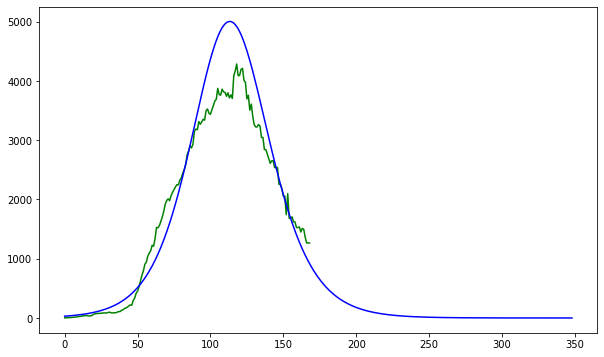

In [36]:
ciudad_i = "Cartagena de Indias"

Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

plt.figure(figsize=(10, 6))

plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values, Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values, color="green")
plt.plot(dias_prediccion, resultado_sir.T[1], color="blue")


## Cali

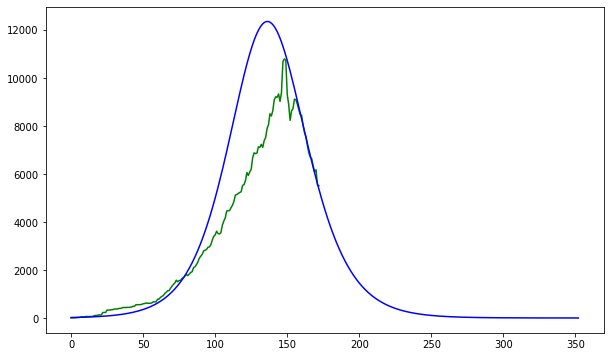

In [37]:
ciudad_i = "Cali"
#p_cali = 2.172*10**6
Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 20
#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.poblacion = p_cali


"""Colombia.objetos_ciudades[ciudad_i ].modelo_sir.ajustar_parametros(
    list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values),
    list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values),
    p_cali
    )"""

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 


plt.figure(figsize=(10, 6))

plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values, Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values, color="green")
plt.plot(dias_prediccion, resultado_sir.T[1], color="blue")

## Medellín

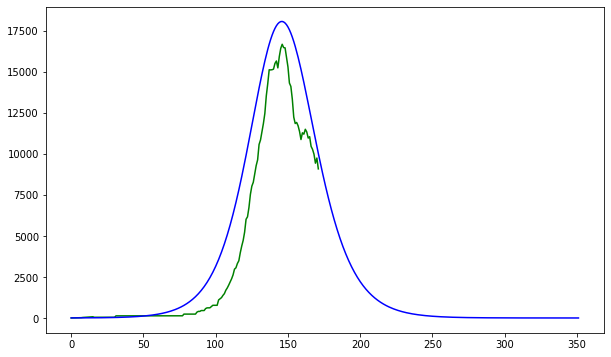

In [38]:
ciudad_i = "Medellín"
p_medellin = 2.382*10**6
Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 4
#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.poblacion = p_medellin


"""Colombia.objetos_ciudades[ciudad_i ].modelo_sir.ajustar_parametros(
    list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values),
    list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values),
    p_cali
    )"""

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 


plt.figure(figsize=(10, 6))

plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values, Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values, color="green")
plt.plot(dias_prediccion, resultado_sir.T[1], color="blue")

## Barranquilla

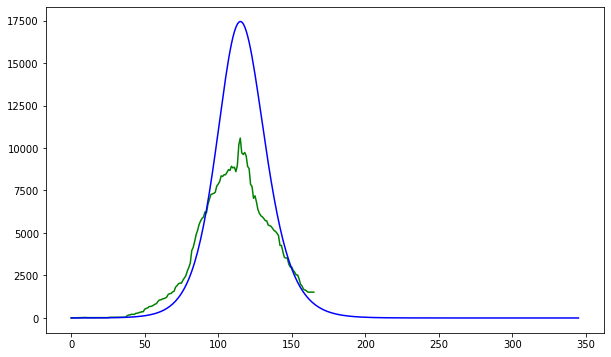

In [39]:
ciudad_i = "Barranquilla"
#p_barranquilla = 1.205*10**6
Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 1
#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.poblacion = p_barranquilla


"""Colombia.objetos_ciudades[ciudad_i ].modelo_sir.ajustar_parametros(
    list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values),
    list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values),
    p_cali
    )"""

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 


plt.figure(figsize=(10, 6))

plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values, Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values, color="green")
plt.plot(dias_prediccion, resultado_sir.T[1], color="blue")

# Intevalos

In [17]:
t_w = 10
t_h = 6
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

## Bogota

In [49]:
ciudad_i = "Bogotá D.C."

### Sir

In [50]:
t_modelo = "SIR"

#### Activos

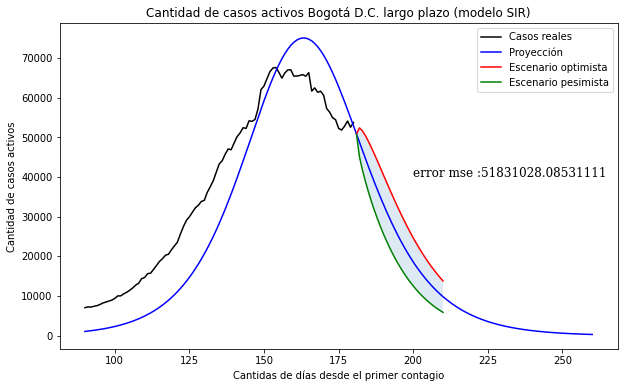

In [51]:
tipo = "activos"

base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion)

sup = resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion) 

inf  =  resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )

inter = 150
vista = 90

plt.figure(figsize=(t_w , t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50], color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))


plt.text(200,40000, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_sir.error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### fallecidos

In [52]:
Colombia.objetos_ciudades[ciudad_i ].modelo_sir.error

{'validacion': 51831028.08531111}

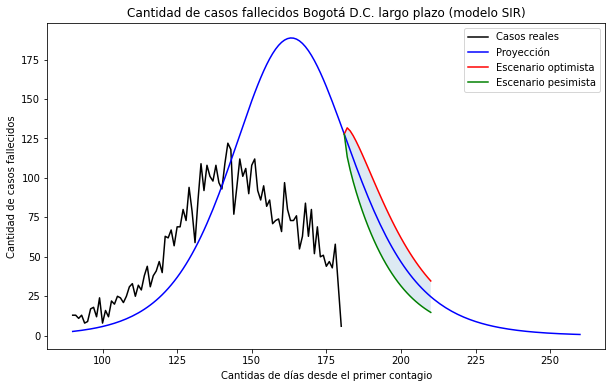

In [53]:
tipo = "fallecidos"
base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["fallecidos"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w , t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["fallecidos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))


plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### Recuperado

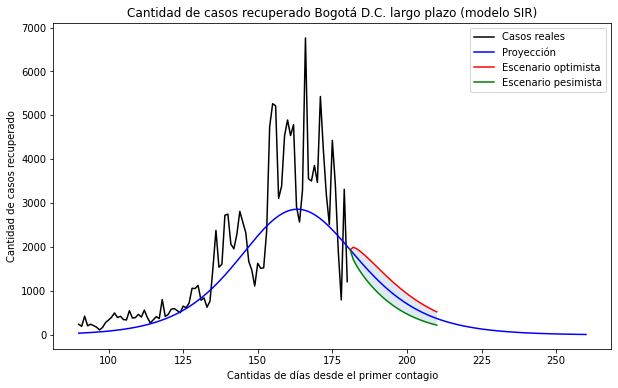

In [54]:

tipo = "recuperado"
base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["recuperados"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w , t_h))

plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["recuperado"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)


plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))



plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

### Arima

In [55]:
t_modelo = "Arima"

#### Activos

In [56]:
Colombia.objetos_ciudades[ciudad_i].modelo_arima["activos"].error

{'validacion': 8343613.549059997}

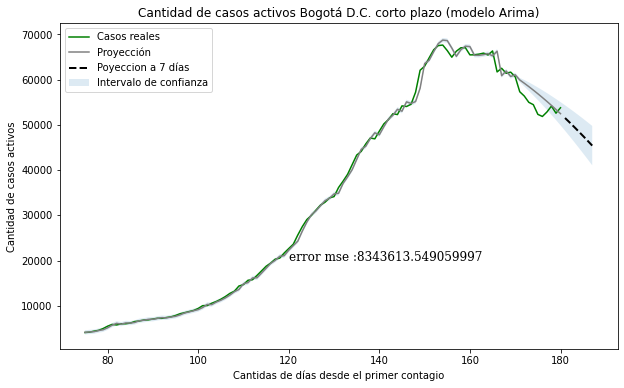

In [57]:

tipo = "activos"
dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))


corte_izq = 75

nforecast = 7
predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima["activos"].modelo_entrenado.get_prediction(0,180 + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,20000, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [58]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima["activos"].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  171
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -1365.862
Date:                Mon, 07 Sep 2020   AIC                           2739.723
Time:                        12:13:59   BIC                           2752.290
Sample:                             0   HQIC                          2744.822
                                - 171                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9860      0.020    101.045      0.000       1.947       2.025
ar.L2         -0.9866      0.020    -49.686      0.000      -1.026      -0.948
ma.L1         -0.8261      0.050    -16.556      0.0

#### fallecidos

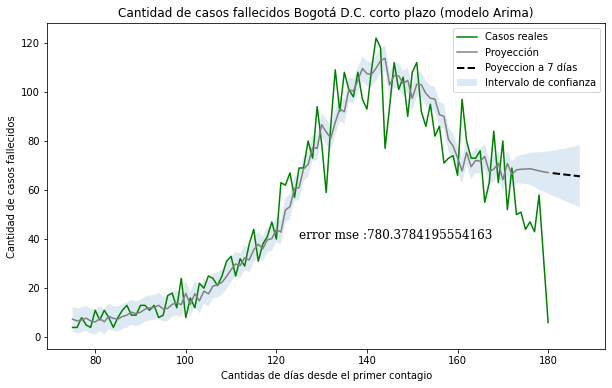

In [64]:

tipo = "fallecidos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))


plt.text(125,40, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [60]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  171
Model:               SARIMAX(5, 1, 3)   Log Likelihood                -580.857
Date:                Mon, 07 Sep 2020   AIC                           1179.714
Time:                        12:13:59   BIC                           1207.936
Sample:                             0   HQIC                          1191.166
                                - 171                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4513      0.845      1.718      0.086      -0.204       3.107
ar.L2         -0.7314      0.803     -0.911      0.362      -2.305       0.842
ar.L3          0.2586      0.216      1.198      0.2

#### Recuperados

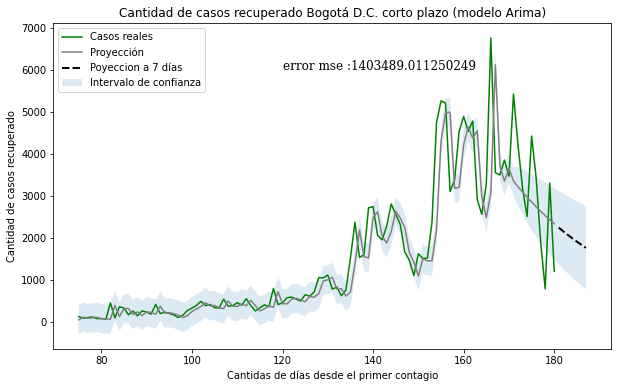

In [65]:

tipo = "recuperado"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,6000, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [62]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  171
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1310.716
Date:                Mon, 07 Sep 2020   AIC                           2627.432
Time:                        12:14:00   BIC                           2636.857
Sample:                             0   HQIC                          2631.257
                                - 171                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8573      0.033     25.802      0.000       0.792       0.922
ar.L2          0.0995      0.045      2.195      0.028       0.011       0.188
sigma2      2.655e+05   8557.372     31.025      0.0

## Cali

In [91]:
ciudad_i = "Cali"

### Sir

In [92]:
t_modelo = "SIR"

#### Activos

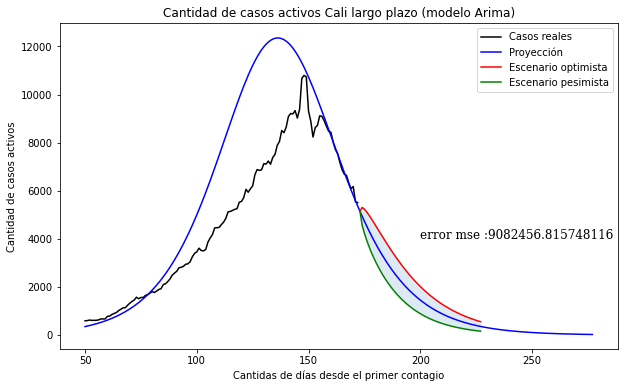

In [103]:
tipo = "activos"
base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion)

sup = resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion) 

inf  =  resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )

inter = 125
vista = 50

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50], color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))

plt.text(200,4000, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_sir.error["validacion"]), fontdict=font)
plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### fallecidos

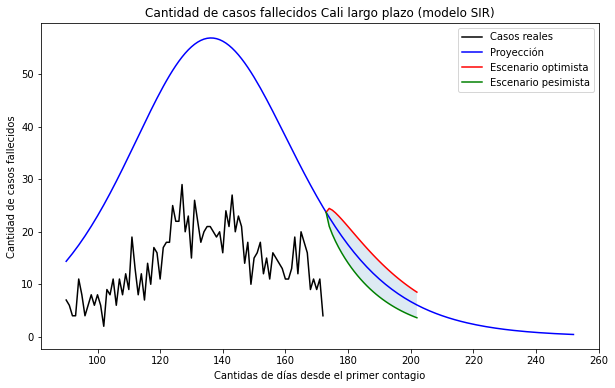

In [94]:
base = np.e
tipo = "fallecidos"
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["fallecidos"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["fallecidos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))



plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### recuperados

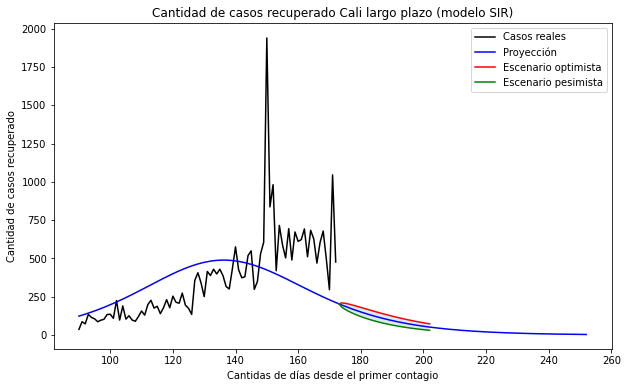

In [95]:
tipo = "recuperado"

base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3


#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["recuperados"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["recuperado"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))


plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

### Arima

In [96]:
t_modelo = "Arima"

#### Activos

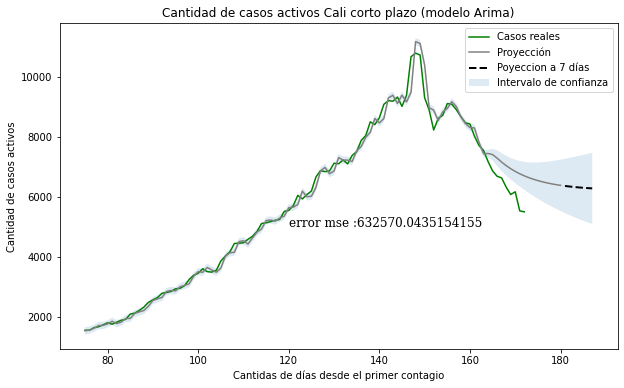

In [97]:
tipo = "activos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

corte_izq = 75

nforecast = 7
predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))


plt.text(120,5000, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')              

In [98]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  164
Model:               SARIMAX(2, 1, 5)   Log Likelihood               -1078.400
Date:                Mon, 07 Sep 2020   AIC                           2172.799
Time:                        12:19:34   BIC                           2197.549
Sample:                             0   HQIC                          2182.848
                                - 164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3869      0.188      7.371      0.000       1.018       1.756
ar.L2         -0.4477      0.184     -2.433      0.015      -0.808      -0.087
ma.L1         -1.1676      0.208     -5.609      0.0

#### fallecidos

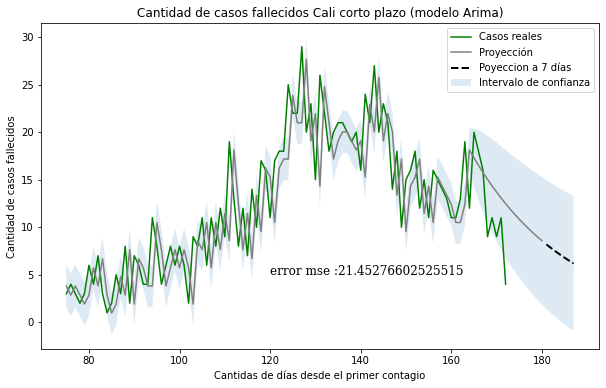

In [99]:

tipo = "fallecidos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))


plt.text(120,5, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [100]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  164
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -430.931
Date:                Mon, 07 Sep 2020   AIC                            865.861
Time:                        12:19:35   BIC                            872.061
Sample:                             0   HQIC                           868.378
                                - 164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9543      0.018     52.538      0.000       0.919       0.990
sigma2        11.0524      0.999     11.067      0.000       9.095      13.010
Ljung-Box (Q):                      136.96   Jarque-

#### Recuperados

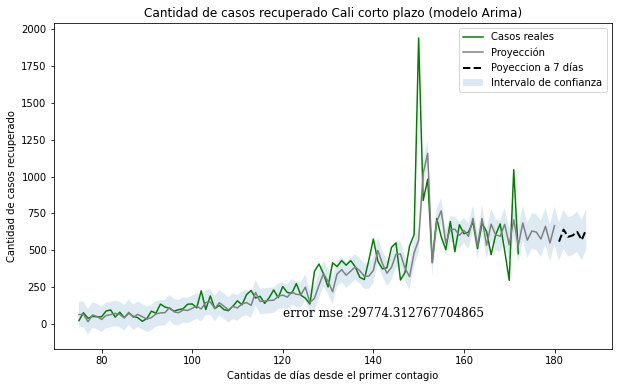

In [101]:
tipo = "recuperado"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,50, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [102]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  164
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -1022.088
Date:                Mon, 07 Sep 2020   AIC                           2064.176
Time:                        12:19:35   BIC                           2095.175
Sample:                             0   HQIC                          2076.760
                                - 164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3422      0.434     -3.096      0.002      -2.192      -0.493
ar.L2          0.4142      0.380      1.091      0.275      -0.330       1.159
ar.L3          1.3982      0.370      3.781      0.0

## Barranquilla

In [104]:
ciudad_i = "Barranquilla"

### Sir

In [105]:
t_modelo = "SIR"

#### activos

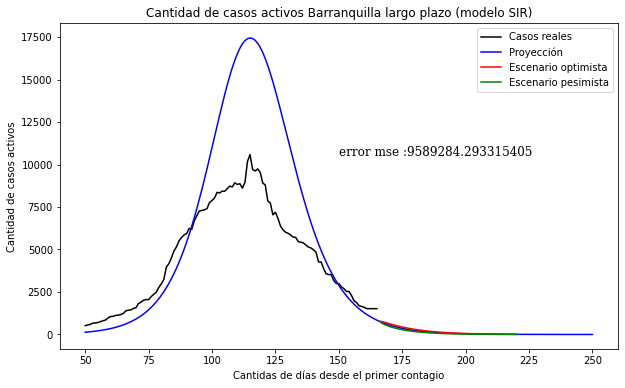

In [106]:
tipo = "activos"
base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion)

sup = resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion) 

inf  =  resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )

inter = 125
vista = 50

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+30], resultado_sir.T[1][vista:-inter+30], color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))


plt.text(150,10500, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_sir.error["validacion"]), fontdict=font)
plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### Fallecidos

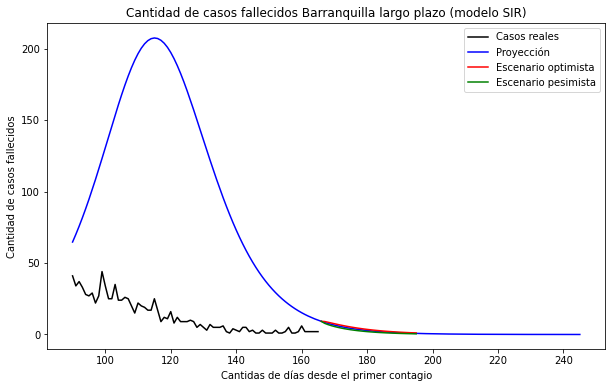

In [107]:
tipo = "fallecidos"
base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["fallecidos"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["fallecidos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))


plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### Recuperados

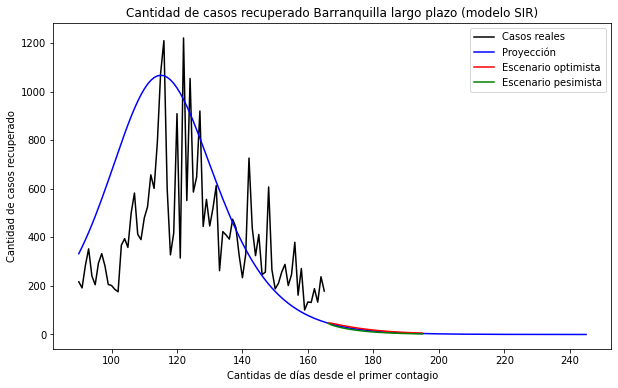

In [108]:
tipo = "recuperado"
base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["recuperados"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["recuperado"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))


plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

### Arima

In [109]:
t_modelo = "Arima"

#### activos

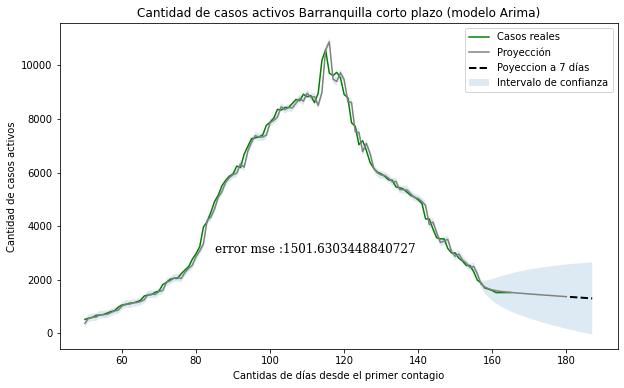

In [117]:
tipo = "activos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))


corte_izq = 50

nforecast = 7
predict = Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(85,3000, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [111]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1067.509
Date:                Mon, 07 Sep 2020   AIC                           2143.018
Time:                        12:20:39   BIC                           2155.243
Sample:                             0   HQIC                          2147.983
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2967      0.073     17.776      0.000       1.154       1.440
ar.L2         -0.1241      0.102     -1.215      0.225      -0.324       0.076
ar.L3         -0.1763      0.040     -4.353      0.0

#### fallecidos

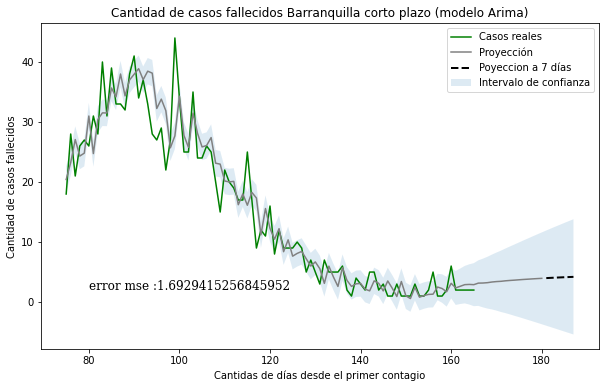

In [118]:
tipo = "fallecidos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))


plt.text(80,2, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [113]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(4, 1, 5)   Log Likelihood                -407.246
Date:                Mon, 07 Sep 2020   AIC                            834.493
Time:                        12:20:39   BIC                            864.991
Sample:                             0   HQIC                           846.880
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3183      0.498     -0.639      0.523      -1.295       0.658
ar.L2          0.2806      0.132      2.127      0.033       0.022       0.539
ar.L3          0.5338      0.240      2.228      0.0

#### recuperados

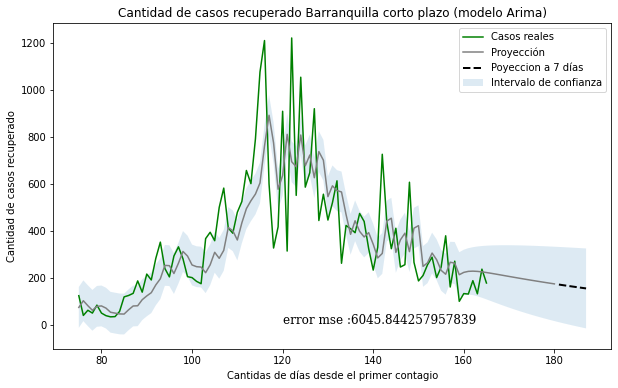

In [114]:
tipo = "recuperado"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,5, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [115]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(2, 0, 4)   Log Likelihood                -986.431
Date:                Mon, 07 Sep 2020   AIC                           1986.861
Time:                        12:20:40   BIC                           2008.255
Sample:                             0   HQIC                          1995.550
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5742      0.197      8.008      0.000       1.189       1.960
ar.L2         -0.5810      0.195     -2.982      0.003      -0.963      -0.199
ma.L1         -1.3009      0.182     -7.144      0.0

## Cartagena

In [119]:
ciudad_i = "Cartagena de Indias"

### Sir

In [120]:
t_modelo = "SIR"

#### activos

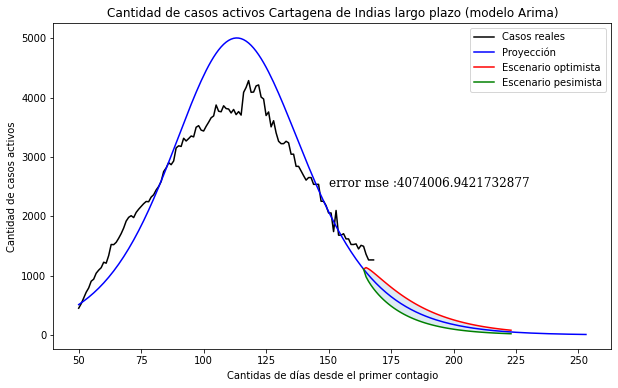

In [132]:
tipo = "activos"
base = np.e

inter_toma = 185
arreglo_transicion =  np.linspace(0 , 1, inter_toma)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion)



sup = resultado_sir.T[1][-inter_toma:] +( resultado_sir.T[1][-inter_toma:] * arreglo_transicion) 

inf  =  resultado_sir.T[1][-inter_toma:] -(resultado_sir.T[1][-inter_toma:] * arreglo_transicion )

inter = 125
vista = 50

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+30], resultado_sir.T[1][vista:-inter+30], color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-inter_toma:-inter], sup[-inter_toma:-inter] , color="red")
plt.plot(dias_prediccion[-inter_toma:-inter], inf[-inter_toma:-inter], color="green")
plt.fill_between(dias_prediccion[-inter_toma:-inter], sup[-inter_toma:-inter], inf[-inter_toma:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))

plt.text(150,2500, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_sir.error["validacion"]), fontdict=font)
plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### fallecidos

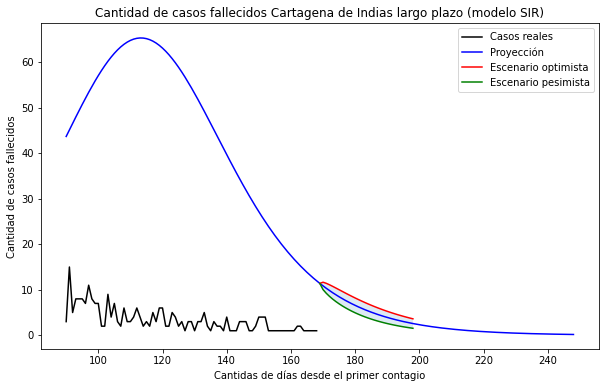

In [122]:
tipo = "fallecidos"

base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["fallecidos"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["fallecidos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))


plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### recuperados

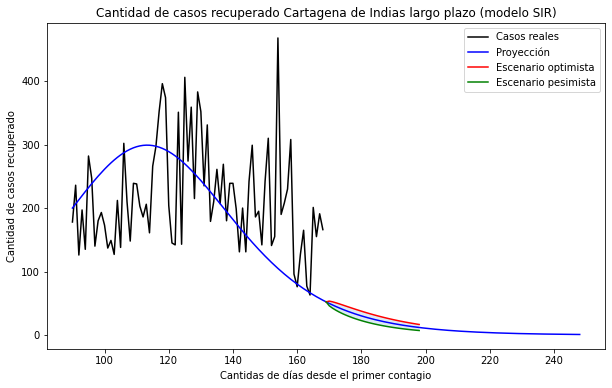

In [123]:
tipo = "recuperado"

base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["recuperados"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["recuperado"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))



plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

### Arima

In [124]:
t_modelo = "Arima"

#### activos

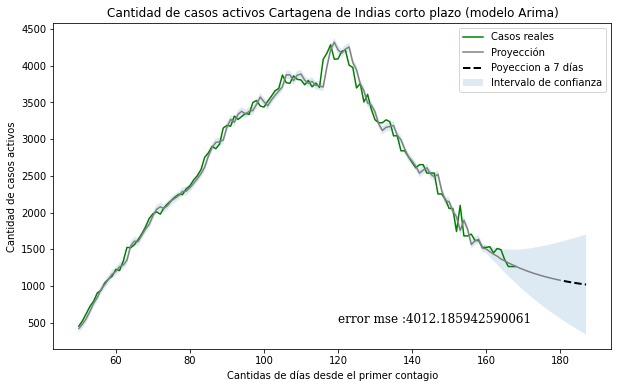

In [125]:

tipo = "activos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))


corte_izq = 50

nforecast = 7
predict = Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,500, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [126]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(5, 1, 1)   Log Likelihood                -932.782
Date:                Mon, 07 Sep 2020   AIC                           1879.564
Time:                        12:21:46   BIC                           1901.047
Sample:                             0   HQIC                          1888.288
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1735      0.197      0.883      0.377      -0.212       0.559
ar.L2          0.3178      0.069      4.587      0.000       0.182       0.454
ar.L3          0.0327      0.074      0.440      0.6

#### fallecidos

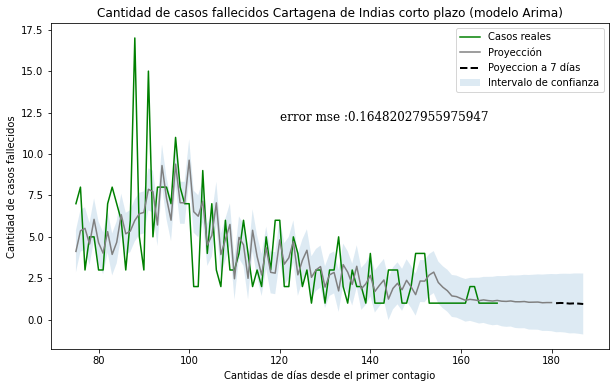

In [127]:
tipo = "fallecidos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)

plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,12, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [128]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(4, 0, 3)   Log Likelihood                -329.570
Date:                Mon, 07 Sep 2020   AIC                            675.140
Time:                        12:21:46   BIC                            699.741
Sample:                             0   HQIC                           685.129
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2852      0.132     -2.155      0.031      -0.545      -0.026
ar.L2          0.1483      0.040      3.724      0.000       0.070       0.226
ar.L3          0.9460      0.047     20.276      0.0

#### recuperados

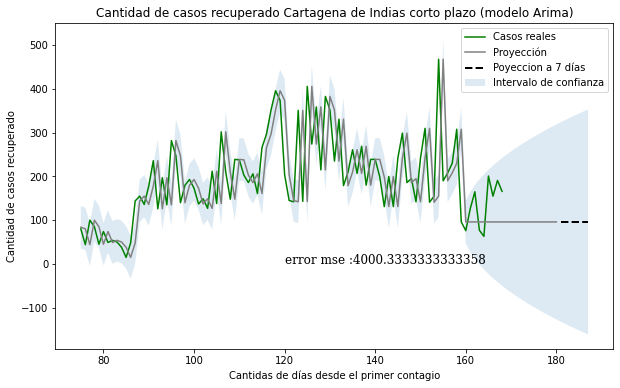

In [129]:
tipo = "recuperado"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,0, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [130]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -905.822
Date:                Mon, 07 Sep 2020   AIC                           1813.644
Time:                        12:21:46   BIC                           1816.713
Sample:                             0   HQIC                          1814.890
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5198.4209    319.469     16.272      0.000    4572.273    5824.569
Ljung-Box (Q):                       86.12   Jarque-Bera (JB):               144.56
Prob(Q):                              0.00   Pr

## Medellin

In [133]:
ciudad_i = "Medellín"

### Sir

In [134]:
t_modelo = "SIR"

#### activos

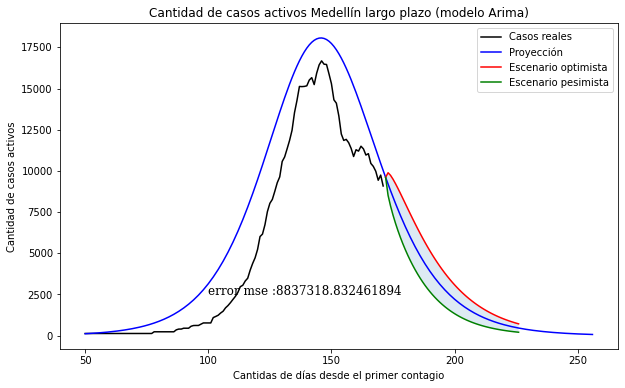

In [146]:
tipo = "activos"
base = np.e

inter_toma = 180
arreglo_transicion =  np.linspace(0 , 1, inter_toma)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))
resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion)



sup = resultado_sir.T[1][-inter_toma:] +( resultado_sir.T[1][-inter_toma:] * arreglo_transicion) 

inf  =  resultado_sir.T[1][-inter_toma:] -(resultado_sir.T[1][-inter_toma:] * arreglo_transicion )

inter = 125
vista = 50

plt.figure(figsize=(t_w,t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+30], resultado_sir.T[1][vista:-inter+30], color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-inter_toma:-inter], sup[-inter_toma:-inter] , color="red")
plt.plot(dias_prediccion[-inter_toma:-inter], inf[-inter_toma:-inter], color="green")
plt.fill_between(dias_prediccion[-inter_toma:-inter], sup[-inter_toma:-inter], inf[-inter_toma:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))

plt.text(100,2500, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_sir.error["validacion"]), fontdict=font)
plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### fallecidos

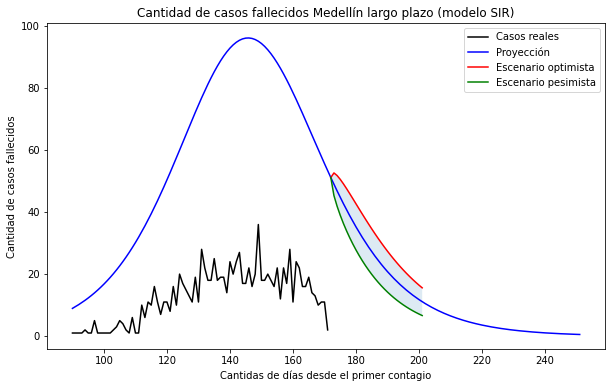

In [136]:
tipo = "fallecidos"

base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["fallecidos"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["fallecidos"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

#### recuperados

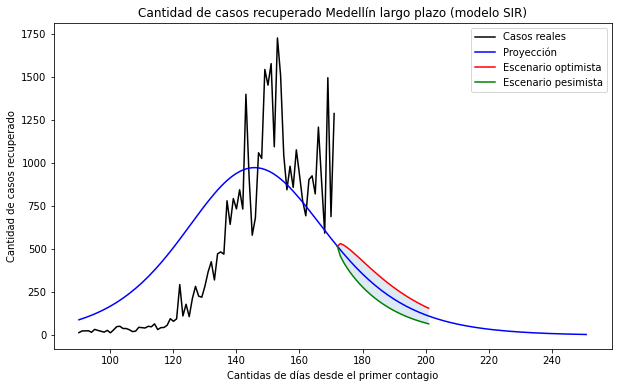

In [137]:
tipo = "recuperado"

base = np.e
arreglo_transicion =  np.linspace(0 , 1, 180)**.5
mas = .3

#Colombia.objetos_ciudades[ciudad_i ].modelo_sir.infectados_iniciales = 30 

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))

factor =  Colombia.objetos_ciudades[ciudad_i ].factores["recuperados"]

resultado_sir  = Colombia.objetos_ciudades[ciudad_i ].modelo_sir.predecir(dias_prediccion) 

sup = (resultado_sir.T[1][-180:] +( resultado_sir.T[1][-180:] * arreglo_transicion)) * factor

inf  =  (resultado_sir.T[1][-180:] -(resultado_sir.T[1][-180:] * arreglo_transicion )) *factor

inter = 150
vista = 90

plt.figure(figsize=(t_w, t_h))


plt.plot(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["dias"].values[vista:], Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["recuperado"].values[vista:], color="black")
plt.plot(dias_prediccion[vista:-inter+50], resultado_sir.T[1][vista:-inter+50] * factor, color="blue")

#plt.fill_between(dias_prediccion[-180:], sup[-180:], sup[-180:], alpha=0.15)


plt.plot(dias_prediccion[-180:-inter], sup[-180:-inter] , color="red")
plt.plot(dias_prediccion[-180:-inter], inf[-180:-inter], color="green")
plt.fill_between(dias_prediccion[-180:-inter], sup[-180:-inter], inf[-180:-inter], alpha=0.15)

plt.title('Cantidad de casos ' + tipo +" " + ciudad_i + " largo plazo (modelo " + t_modelo + ")")
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Escenario optimista',
                  'Escenario pesimista'))

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

### Arima

In [138]:
t_modelo = "Arima"

#### activos

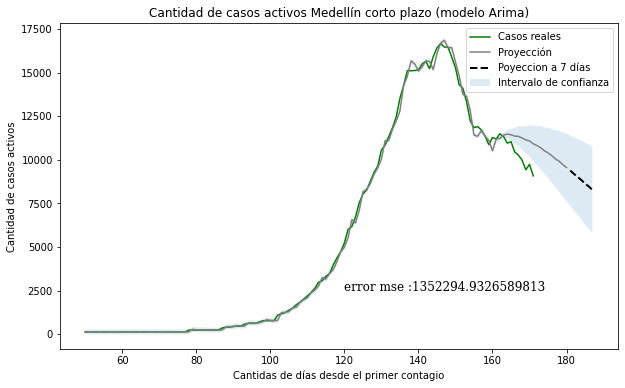

In [139]:
tipo = "activos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values))+180))


corte_izq = 50

nforecast = 7
predict = Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos["activos"].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))


plt.text(120,2500, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [140]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  163
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -1096.634
Date:                Mon, 07 Sep 2020   AIC                           2215.267
Time:                        12:22:46   BIC                           2249.299
Sample:                             0   HQIC                          2229.084
                                - 163                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2885      0.737     -0.391      0.695      -1.733       1.156
ar.L2          1.2526      0.507      2.472      0.013       0.259       2.246
ar.L3          1.0969      0.440      2.495      0.0

#### fallecidos

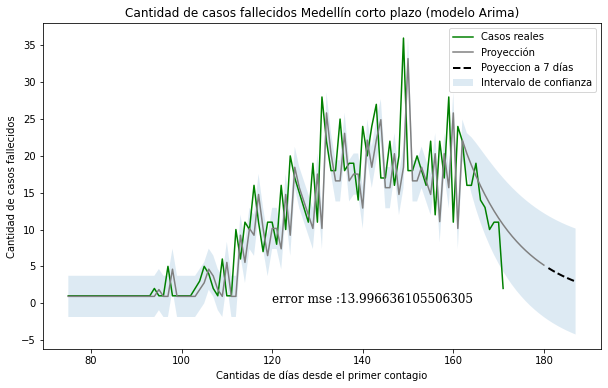

In [141]:
tipo = "fallecidos"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,0, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [142]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  163
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -464.146
Date:                Mon, 07 Sep 2020   AIC                            932.292
Time:                        12:22:47   BIC                            938.480
Sample:                             0   HQIC                           934.804
                                - 163                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9227      0.017     54.292      0.000       0.889       0.956
sigma2        17.2103      0.941     18.299      0.000      15.367      19.054
Ljung-Box (Q):                      124.66   Jarque-

#### recuperados

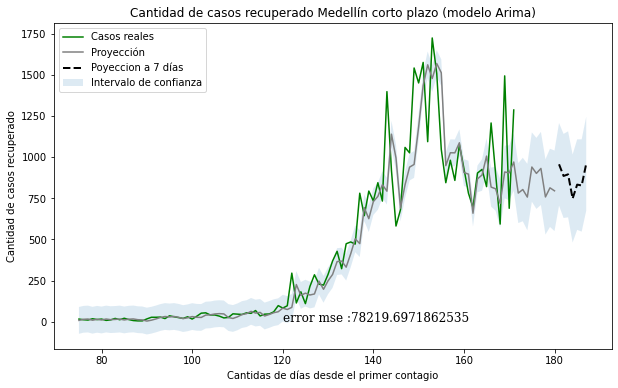

In [147]:
tipo = "recuperado"

dias_prediccion = list(range(0, len(list(Colombia.objetos_ciudades[ciudad_i ].df_datos_modelos[tipo].values))+180))


corte_izq = 75

nforecast = 7

predict = Colombia.objetos_ciudades[ciudad_i].modelo_arima[tipo].modelo_entrenado.get_prediction(0,180 + nforecast)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)


plt.figure(figsize=(t_w, t_h))
plt.plot(dias_prediccion[corte_izq:-180] ,list(Colombia.objetos_ciudades[ciudad_i].df_datos_modelos[tipo].values)[corte_izq:], color="green")
plt.plot(idx[corte_izq:-nforecast], predict.predicted_mean[corte_izq:-nforecast], 'gray')
plt.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
plt.fill_between(idx[corte_izq:], predict_ci[corte_izq:, 0], predict_ci[corte_izq:, 1], alpha=0.15)


plt.title('Cantidad de casos ' + tipo + " " + ciudad_i + " corto plazo (modelo " + t_modelo + ")" )
plt.xlabel('Cantidas de días desde el primer contagio')
plt.ylabel('Cantidad de casos ' + tipo)
plt.gca().legend(('Casos reales',
                  'Proyección',
                  'Poyeccion a ' + str(nforecast ) + " días",
                  'Intervalo de confianza'))

plt.text(120,0, "error mse :"  + str(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].error["validacion"]), fontdict=font)

plt.savefig('img/' + ciudad_i + "-" +  t_modelo + "-" + tipo  +   '.png')

In [144]:
print(Colombia.objetos_ciudades[ciudad_i ].modelo_arima[tipo].modelo_entrenado.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  163
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -992.792
Date:                Mon, 07 Sep 2020   AIC                           2001.584
Time:                        12:22:47   BIC                           2026.285
Sample:                             0   HQIC                          2011.613
                                - 163                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1247      0.119     -1.046      0.296      -0.358       0.109
ar.L2         -0.1005      0.119     -0.842      0.400      -0.335       0.134
ar.L3         -0.9490      0.132     -7.189      0.0

# Generar index

In [ ]:
%%writefile index.html
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <title>Dashboard</title>
	<style>
	.h2 {
		text-align: center; color: black ;
		}
	.topright {
       position: absolute;
       right: 0;
       top: 1;
       display: block;
       height: 125px;
       width: 125px;
       background: url(TRbanner.gif) no-repeat;
       text-indent: -999em;
       text-decoration: none;
	   }
    </style>
    
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css" integrity="sha384-JcKb8q3iqJ61gNV9KGb8thSsNjpSL0n8PARn9HuZOnIxN0hoP+VmmDGMN5t9UJ0Z" crossorigin="anonymous">
  </head>
  <body>
  
	
    
    <div class="jumbotron text-center" style="margin-bottom:0">
        <h1 class="h2">Proyecto Analítica Predictiva</h1>
        <h2 class="h2">CASOS DE CORONAVIRUS (COVID-19) EN LAS PRINCIPALES CIUDADADES DE COLOMBIA</h2>
    </div>


    <nav class="navbar navbar-expand-sm bg-dark navbar-dark" style="width: 100%;padding: 5px 45%;">
        <div>
            <select id="region" name="region" class="custom-select-sm" onchange="selectPlot()" style="width: 250px;">
				<option name="region" selected="true" >seleccione la ciudad</option>
                <option value="Bogotá">Bogotá</option>
                <option value="Medellin">Medellin</option>
                <option value="Cali">Cali</option>
                <option value="Barranquilla">Barranquilla</option>
                <option value="Cartagena">Cartagena</option>
      </select>
        </div>  

      

    </nav>
	<div class="card" style="min-height: 500px;">
       <TABLE style="margin: auto; width: 85%;"> 

         <TR> 
            <div class="myImage" id="sel">

            </div> 
         <TD> 
             <div class="myImage" id="Bogotá" style="display:none"> 
                <img src="img/Bogotá D.C.-Arima-activos.png" alt="ArimaActivos"   title="ARIMA-ACTIVOS"  > 
            </div> </TD>
         <TD> 
             <div class="myImage" id="Bogotá" style="display:none"> 
                <img src="img/Bogotá D.C.-Arima-fallecidos.png"  alt="ArimaFallecidos"   title="ARIMA_FALLECIDOS" > 
            </div> 
        </TD>
		 <tr>

         <TD> 
             <div class="myImage" id="Bogotá" style="display:none"> 
                <img src="img/Bogotá D.C.-Arima-recuperado.png"      alt="BogotaRecuperado"  title="ArimaRecuperado" > 
            </div> 
        </TD>

		 <TD> 
             <div class="myImage" id="Bogotá" style="display:none"> 
                <img src="img/Bogotá D.C.-SIR-activos.png"      alt="BogotaSIRActivo"  title="SIR-activo" > 
            </div> 
        </TD>
		 </tr>
		 <tr>
		 <TD> 
             <div class="myImage" id="Bogotá" style="display:none"> 
                <img src="img/Bogotá D.C.-SIR-fallecidos.png"      alt="BogotaSIRFallecido"  title="SIRFallecido" > 
            </div> 
        </TD>
		 <TD> 
             <div class="myImage" id="Bogotá" style="display:none"> 
                <img src="img/Bogotá D.C.-SIR-recuperado.png"      alt="BogotaSIRRecuperado"  title="SIRRecuperado" >
             </div> 
        </TD>
         </tr>
         
		 <TD> 
             <div class="myImage" id="Medellin" style="display:none"> 
                <img src="img/Medellín-Arima-activos.png" alt="ActivosMedellinCortoPlazo"  title="Activos Corto Plazo" >
             </div>
        </TD> 

         <TD> 
             <div class="myImage" id="Medellin" style="display:none">
                 <img src="img/Medellín-Arima-fallecidos.png"   alt="FallecidosMedellinCortoPlazo"  title="Fallecidos Corto Plazo" >
                 </div> 
        </TD>

		 <tr>
		 <TD>
              <div class="myImage" id="Medellin" style="display:none"> 
                <img src="img/Medellín-Arima-recuperado.png"      alt="RecuperadoMedCortoPlazo"  title="Recuperados Corto Plazo" > 
            </div> 
        </TD>
         <TD> <div class="myImage" id="Medellin" style="display:none">
             <img src="img/Medellín-SIR-activos.png"      alt="ActivosSIR"  title="ACTIVOS Largo Plazo" >
             </div> 
        </TD>

		 </tr>
		 <tr>
		 <TD> 
             <div class="myImage" id="Medellin" style="display:none">
                 <img src="img/Medellín-SIR-fallecidos.png"      alt="MedellinFallecidosSIR"  title="Fallecidos Largo Plazo" >
            </div> 
        </TD>

         <TD> <div class="myImage" id="Medellin" style="display:none">
             <img src="img/Medellín-SIR-recuperado.png"      alt="MedellinSIRRecuperados"  title="Recuperados Largo Plazo" >
            </div> 
        </TD>

		 </tr>
		 <TD> 
             <div class="myImage" id="Cali" style="display:none">
                 <img src="img/Cali-Arima-activos.png"alt="CaliArimaActivos"  title="Activos Corto Plazo" > 
                </div>
             </TD> 
         <TD>
              <div class="myImage" id="Cali" style="display:none"> <img src="img/Cali-Arima-fallecidos.png"  alt="CaliARIMAFallecidos"  title="Fallecidos Corto Plazo" > 
            </div> 
        </TD>

		 <tr>
         <TD> 
            <div class="myImage" id="Cali" style="display:none">
             <img src="img/Cali-Arima-recuperado.png"alt="CaliArimaRecuperados"  title="Recuperados Corto Plazo" > 
            </div> 
        </TD> 
         <TD> 
             <div class="myImage" id="Cali" style="display:none"> 
                <img src="img/Cali-SIR-activos.png"      alt="CaliSIRActivos"  title="Activos Largo Plazo" > 
        </div>
        </TD>
		 </tr>
		 <tr>
		 <TD> 
             <div class="myImage" id="Cali" style="display:none">
                 <img src="img/Cali-SIR-fallecidos.png" alt="CaliSIRFallecidos"  title="Falleciso Largo Plazo" >
                 </div>
             </TD> 
         <TD>
              <div class="myImage" id="Cali" style="display:none"> 
                <img src="img/Cali-SIR-recuperado.png"   alt="CaliSIRRecuperado"  title="Recuperado Largo Plazo" > 
            </div> 
        </TD>

		 </tr>
		 <TD> 
             <div class="myImage" id="Barranquilla" style="display:none">
                 <img src="img/Barranquilla-Arima-activos.png" alt="BarranquillaActivos"  title="Activos" >
                 </div> 
            </TD> 
         <TD> 
             <div class="myImage" id="Barranquilla" style="display:none"> 
                <img src="img/Barranquilla-Arima-fallecidos.png" alt="BarranquillaFallecidos"  title="Fallecidos" >
             </div> 
        </TD>

		 <tr>
		 <TD>
              <div class="myImage" id="Barranquilla" style="display:none"> 
                <img src="img/Barranquilla-Arima-recuperado.png" alt="BarranquillaRecuperado"  title="Recuperado" >
             </div> 
            </TD> 
         <TD> 
             <div class="myImage" id="Barranquilla" style="display:none">
                 <img src="img/Barranquilla-SIR-activos.png"      alt="BarranquillaSIRActivos"  title="SIR-activos" >
                 </div>
                 </TD>
		 </tr>
		<tr>
		 <TD> 
             <div class="myImage" id="Barranquilla" style="display:none"> 
                <img src="img/Barranquilla-SIR-fallecidos.png"alt="BarranquillaSIRFallecidos"  title="SIR-fallecidos" > 
            </div> 
        </TD> 

         <TD> <div class="myImage" id="Barranquilla" style="display:none"> 
            <img src="img/Barranquilla-SIR-recuperado.png"      alt="BarranquillaSIRRecuperado"  title="SIR-recuperado" >
         </div>
         </TD>
		 </tr>
		 <TD> 
             <div class="myImage" id="Cartagena" style="display:none"> 
                <img src="img/Cartagena de Indias-Arima-activos.png" alt="CartagenaARIMActivos"  title="Activos Corto Plazo" > 
            </div>
         </TD> 

         <TD> 
             <div class="myImage" id="Cartagena" style="display:none">
             <img src="img/Cartagena de Indias-Arima-fallecidos.png"  alt="CartagenaARIMAFallecidos"  title=" Fallecidos Corto Plazo" >
             </div> </TD>
		 <tr>

		 <TD> 
             <div class="myImage" id="Cartagena" style="display:none">
                 <img src="img/Cartagena de Indias-Arima-recuperado.png"alt="CartagenaARIMARecuperado"  title="Recuperados Corto Plazo" >
                 </div>
             </TD> 

         <TD> <div class="myImage" id="Cartagena" style="display:none">
             <img src="img/Cartagena de Indias-SIR-activos.png"      alt="CartagenaActivosSIRLP"  title="ACTIVOS Largo Plazo" > 
            </div>
         </TD>
		 </tr>
		 <tr>
         <TD> <div class="myImage" id="Cartagena" style="display:none"> 
            <img src="img/Cartagena de Indias-SIR-fallecidos.png"alt="CartagenaSIRFallecidos"  title="Fallecidos Largo Plazo" >
         </div> </TD> 
         <TD> <div class="myImage" id="Cartagena" style="display:none">
             <img src="img/Cartagena de Indias-SIR-recuperado.png"      alt="CartagenaRecuperadosSIRLP"  title="Recuperados Largo Plazo" >
             </div> </TD>
		 </tr>
         </TR> 
         </TABLE>
	</div>

    <div>

    <script>
      function selectPlot() {
        var region = document.getElementById("region").value;
        var images = document.getElementsByClassName("myImage");
        for (var i = 0; i < images.length; i++) {
          if (images[i].id == region) {
            images[i].style.display = "block"
          }else{
            images[i].style.display = "none"
          }
        }
      }
    </script>
	
    
    <div class="jumbotron text-center" style="margin-bottom:0;">
        <p align="left">
            <font size=2>Elaborado por los estudiates de la espacializaión y maestria en Analítica:</font>
        
            <ul id="lista">
                     <li>Luis Gabriel Diaz Fonseca</li>
                     <li>Diego Camilo Mayorga Ballesteros</li>
                     <li>Cristian Camilo Londoño Ramirez</li>
                     <li>Eduardo Alberto González Escobar</li>
            </ul>

        </p>
            
      </div>
      
  </body>
</html>

# Guardar modelos ajustados

In [ ]:
nombreArchivo = "objeto_modelos_ajustes.pyob"
with open(nombreArchivo,'wb') as archivo:
  pickle.dump(Colombia,archivo)
  archivo.close()